In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
from colors import cyan,yellow

from numpy import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from skimage import io

from scipy.ndimage.morphology import binary_closing,binary_opening
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

from glob import glob
from os import system
    
# basis function
def sigmoid(x) :
    return 1.0/(1.0+exp(-x))

# feature vector
def features(x,degree=3) :
    x = squeeze(x)
    fx = [ sigmoid(sigma*(x-mu)) for mu in linspace(0.25,.75,num=degree) for sigma in [-20,20] ]
    return stack(fx,axis=-1)


def fit(data,threshold = 25000,t_final=24,x_width=1.0) :
    
    # create coordinate meshes
    n_frames,height,width,n_channels = data.shape
    x,t = linspace(0,x_width,num=width),linspace(0,t_final,num=n_frames)

    xx,tt = meshgrid(x,t)
    X,Y = meshgrid(x,linspace(0,1,num=height))
    cfp,yfp,rfp = 0,1,2

    # setting values outside grid squares to nan
    mask = data[-1,...,rfp]/amax(data[-1,...,rfp]) < 0.5
    mask = stack([[ mask for _ in range(n_frames) ] for _ in range(n_channels) ],axis=-1)
    
    # intensity normalisation
    data /= data[...,rfp][...,None]
    data[mask] = NaN
    
    # create regressors
    yfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])
    cfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

    # fit both channels for each timepoint
    yfp_predictions,cfp_predictions = [],[]
    for t in range(n_frames):

        input = data[t,...,yfp]
        yfp_predictor.fit(X[~isnan(input)].reshape(-1,),input[~isnan(input)].reshape(-1,))
        yfp_predictions += [yfp_predictor.predict(x.reshape(-1,))]

        input = data[t,...,cfp]
        cfp_predictor.fit(X[~isnan(input)].reshape(-1,),input[~isnan(input)].reshape(-1,))
        cfp_predictions += [cfp_predictor.predict(x.reshape(-1,))]

    predictions = stack([yfp_predictions,cfp_predictions],axis=-1)
    return xx,tt,predictions,yfp_predictor,cfp_predictor

In [17]:
hyperstack = io.imread('./20191121 exrep 10uM IPTG.lif - TileScan 4_Merging_002-small.tif')[:,250:1700,100:,:]
#20191121 exrep 10uM IPTG.lif - TileScan 4_Merging_002-small.tif
#20200108 exrep 10uM IPTG_small.tif
#20191127 exrep 10uM IPTG_flipped_small.tif
ntime,height,width,channels = hyperstack.shape

assert channels == 3
cfp,yfp,rfp = 0,1,2

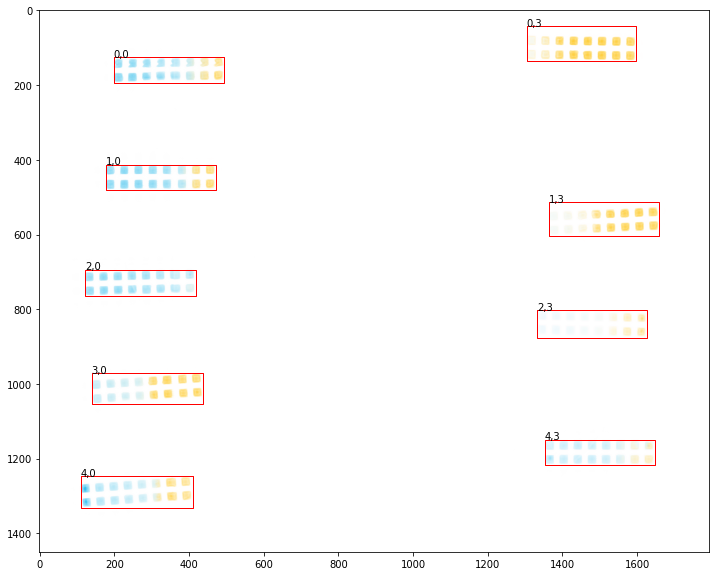

In [20]:
gridmask = hyperstack[-1,:,:,rfp] > mean(hyperstack[-1,:,:,rfp])
gridmask = binary_closing(binary_opening(gridmask,structure=ones((10,10))),structure=ones((20,20)))

region_boxes =  array([ region.bbox for region in regionprops(label(clear_border(gridmask))) if region.area < 1e5 ])
region_centre = array([ [(box[0]+box[2])/2,(box[1]+box[3])/2] for box in region_boxes  ])

region_index =  array([ [int(5*y/height)  ,int(4*x/width)   ] for y,x in region_centre ])
regions = list(zip(region_index,region_boxes))

fig = figure(figsize=(12,12))
imshow(hyperstack[-1,:,:,yfp],cmap='yellow')
imshow(hyperstack[-1,:,:,cfp],cmap='cyan')


for (i,j),(miny, minx, maxy, maxx) in regions:
    text(minx,miny,  '{},{}'.format(i,j))

    rectangle = Rectangle((minx,miny), maxx-minx, maxy-miny)
    fig.axes[0].add_collection(PatchCollection([rectangle],facecolor='',edgecolor='red'))

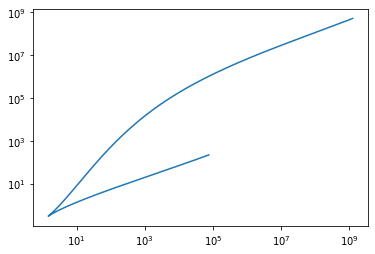

In [28]:
plot(*genfromtxt('limit-curve.csv').T)
yscale('log')
xscale('log')

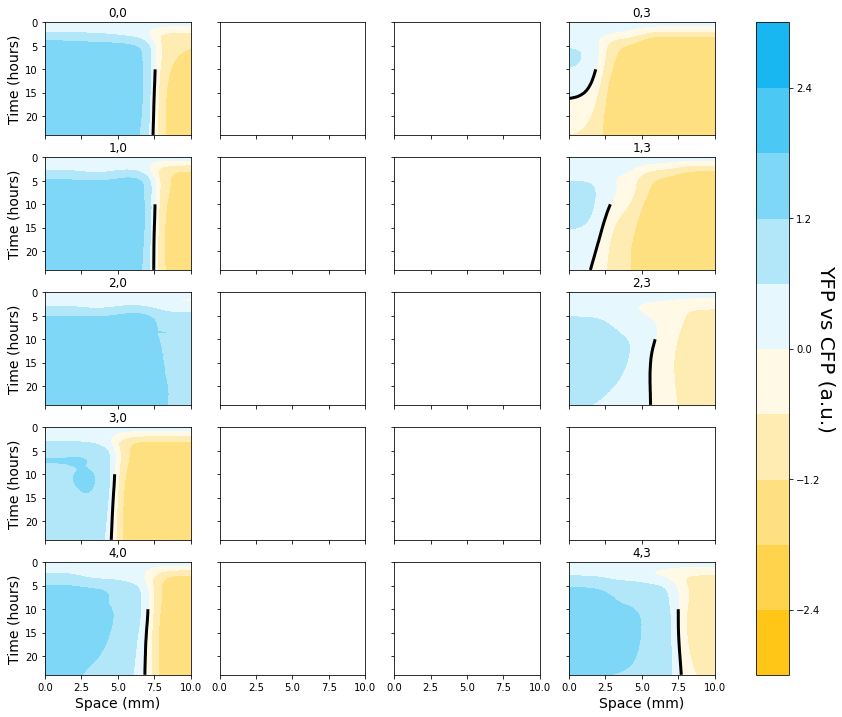

In [21]:
fig, axs = subplots(5,4,figsize=(15,12),sharex=True,sharey=True)
axs[0,0].invert_yaxis()

for (i,j),(miny, minx, maxy, maxx) in regions:

    hyperstack_region = hyperstack[:,miny:maxy,minx:maxx,:]
    xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit( hyperstack_region.astype(float) )

    axs[i,j].set_title('{},{}'.format(i,j))
    cs = axs[i,j].contourf(10*xx,tt,arcsinh(predictions[...,1]-predictions[...,0]),
                           levels=linspace(-3,3,11), cmap='cyanyellow',vmin=-3,vmax=3)

    difference = predictions[...,0].T-predictions[...,1].T
    difference[(tt<10).T] = NaN
    axs[i,j].contour(10*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])
    
    axs[i,j].set_xlabel('Space (mm)',fontsize=14)
    axs[i,j].set_ylabel('Time (hours)',fontsize=14)
    
for ax in axs.flat:
    ax.label_outer()
    
cbar = fig.colorbar(cs, ax=axs.ravel().tolist())
cbar.set_label('YFP vs CFP (a.u.)', rotation=270, fontsize=20,labelpad=15)

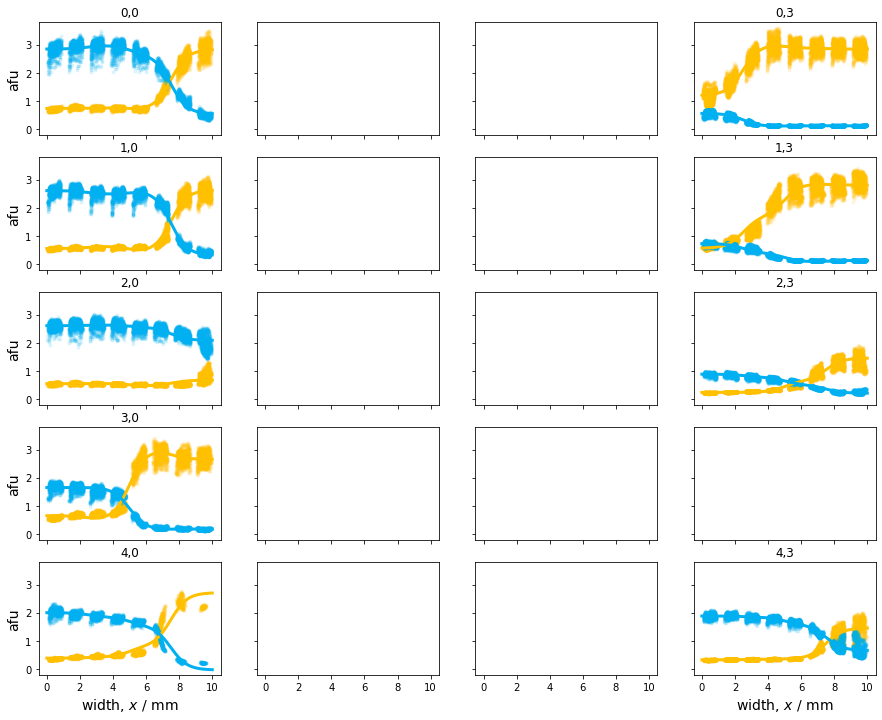

In [22]:
fig, axs = subplots(5,4,figsize=(15,12),sharex=True,sharey=True)
for (i,j),(miny, minx, maxy, maxx) in regions:

    hyperstack_region = hyperstack[:,miny:maxy,minx:maxx,:]
    data = hyperstack_region.astype(float)
    xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit( data )

    axs[i,j].set_title('{},{}'.format(i,j))
    axs[i,j].plot(10*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
    axs[i,j].plot(10*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

    axs[i,j].plot(10*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
    axs[i,j].plot(10*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

    axs[i,j].set_xlabel('width, $x$ / mm',fontsize=14)
    axs[i,j].set_ylabel('afu',fontsize=14)
    
for ax in axs.flat:
    ax.label_outer()